# 4. K Nearest Neighbors
***
- One of the easiest machine learning algorithms to implement
- Classification algorithm that makes prediction based on a defined number of nearest neighbors
    - This is the only hyperparameter
    - Well, only one that's mandatory
- Doesn't require any "learning" - only a simple distance calculation
- Basic idea: A sample is classified by a majority vote of its nearest neighbors
- The algorithm classifies an instance based on the majority votes from k nearest instances
- Gotchas:
    - It's a distance-based algorithm, so it's a good idea to standardize your data before training


## Math behind

- KNN boils down to a single formula for distance
- You can choose from many distance metrics, such as Cosine or Euclidean distance
- We'll use Euclidean distance
- Here's the formula:

$$ \Large d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + ... + (p_n - q_n)^2} $$

- Or in a more compact way:

$$ \Large d(p, q) = \sqrt{\sum_{i=1}^n (p_i - q_i)^2} $$

- It's a simple straight line distance that's easy to implement in Python

<br><br>

## Implementation
- The `KNN` class was writen with having Scikit-Learn API syntax in mind
- The value for `k` is set by default to 3, and is stored to the constructor (`__init__()`) alongside `X_train` and `y_train`, initially set to `None`
- The `_euclidean_distance(p, q)` is a private method which implements the formula from above
- The `fit(X, y)` method does basically nothing - it just stores training data to the constructor
- The `predict(X)` method calculates distances between every row in `X` and every row in `X_train`. The distances are then sorted and only top k are kept. The classificatin is than made by calculating statistical mode

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [2]:
class KNN:
    '''
    A class which implement k Nearest Neighbors algorithm from scratch.
    '''
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
        
    @staticmethod
    def _euclidean_distance(p, q):
        '''
        Private method, calculates euclidean distance between two vectors.
        
        :param p: np.array, first vector
        :param q: np.array, second vector
        :return: float, distance
        '''
        return np.sqrt(np.sum((p - q) ** 2))
        
    def fit(self, X, y):
        '''
        Trains the model.
        No training is required for KNN, so `fit(X, y)` saves both parameteres
        to the constructor.
        
        :param X: pd.DataFrame, features
        :param y: pd.Series, target
        :return: None
        '''
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        '''
        Predicts the class labels based on nearest neighbors.
        
        :param X: pd.DataFrame, features
        :return: np.array, predicted class labels
        '''
        predictions = []
        for p in X:
            euc_distances = [self._euclidean_distance(p, q) for q in self.X_train]
            sorted_k = np.argsort(euc_distances)[:self.k]
            k_nearest = [self.y_train[y] for y in sorted_k]
            predictions.append(stats.mode(k_nearest)[0][0])
            
        return np.array(predictions)

<br>

## Testing
- We'll use the *breast cancer* dataset from Scikit-Learn:

In [3]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target 

- The below code cell applies train/test split to the dataset:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- You can now initialize and "train" the model, and afterwards make predictions:

In [5]:
model = KNN()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [6]:
preds

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0])

In [7]:
y_test

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0])

- As we can see, the arrays are quite similar but they have some differences
- Let's calculate accuracy to evaluate the model:

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.9298245614035088

- The overall performance seems to be good out of the box
- Let's tweak it by finding the optimal K value

<br>

## K Optimization
- K value of 3 maybe isn't the best choice
- We'll train and evaluate the model for every odd number from 1 to 15
- The results are stored to `evals`:

In [9]:
evals = []

for k in range(1, 16, 2):
    model = KNN(k=k)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    evals.append({'k': k, 'accuracy': accuracy})

- Let's visually inspect the best K:

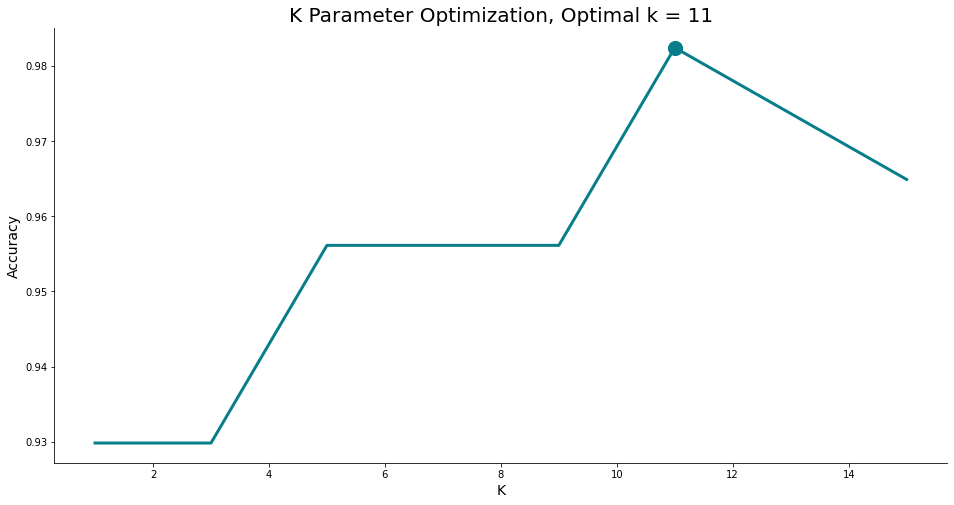

In [10]:
evals = pd.DataFrame(evals)
best_k = evals.sort_values(by='accuracy', ascending=False).iloc[0]

plt.figure(figsize=(16, 8))
plt.plot(evals['k'], evals['accuracy'], lw=3, c='#087E8B')
plt.scatter(best_k['k'], best_k['accuracy'], s=200, c='#087E8B')
plt.title(f"K Parameter Optimization, Optimal k = {int(best_k['k'])}", size=20)
plt.xlabel('K', size=14)
plt.ylabel('Accuracy', size=14)
plt.savefig('images/004_KNN_k_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

- The K value of 11 seems to work the best with our dataset
- You can now retrain the model with having this in mind
    - `model = KNN(k=11)`
- Let's compare performance with Scikit-Learn model next

<br>

## Comparison with Scikit-Learn
- We want to know if our model is good, so let's compare it with `KNeighborsClassifier` model from Scikit-Learn

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

In [12]:
accuracy_score(y_test, knn_preds)

0.956140350877193

- They are more or less the same, but we didn't do K optimization for Scikit-Learn model